In [7]:
from numba import njit
from hftbacktest import (
    SingleAssetHftBacktest_,
    HftBacktest,
    FeedLatency,
    SquareProbQueueModel,
    Linear,
    Stat,
    BUY,
    SELL,
    GTX,
    GTC,
    ConstantLatency,
    PartialFillExchange
)

In [8]:
@njit
def simple_two_sided_quote(hbt: SingleAssetHftBacktest_, stat):
    max_position = 10
    half_spread = hbt.tick_size
    skew = 0.01
    order_qty = 1
    last_order_id = -1
    order_id = 0

    # Checks every 0.1s
    while hbt.elapse(100_000):
        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        # Obtains the current mid-price and compute the reservation price.
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0

        # 
        reservation_price = mid_price - skew * hbt.position * hbt.tick_size
        
        buy_order_price = 150
        sell_order_price = 130
        last_order_id = -1
        # Cancel all outstanding orders
        for order in hbt.orders.values():
            if order.cancellable:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id

        # All order requests are considered to be requested at the same time.
        # Waits until one of the order cancellation responses is received.
        if last_order_id >= 0:
            hbt.wait_order_response(last_order_id)

        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        if hbt.position < max_position:
            # Submits a new post-only limit bid order.
            order_id += 1
            hbt.submit_buy_order(
                order_id,
                buy_order_price,
                order_qty,
                GTC
            )
            last_order_id = order_id

        if hbt.position > -max_position:
            # Submits a new post-only limit ask order.
            order_id += 1
            hbt.submit_sell_order(
                order_id,
                sell_order_price,
                order_qty,
                GTC
            )
            last_order_id = order_id

        # All order requests are considered to be requested at the same time.
        # Waits until one of the order responses is received.
        if last_order_id >= 0:
            hbt.wait_order_response(last_order_id)

        # Records the current state for stat calculation.
        stat.record(hbt)

In [9]:
# This backtest assumes market maker rebates.
# https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf
    
hbt = HftBacktest(
    [
        "/home/danny/hftbacktest/test_dbn1.npz"
    ],
    tick_size=0.01,
    lot_size=1,
    maker_fee=0,
    taker_fee=0.0,
    order_latency=ConstantLatency(0.0001, 0.0001),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    exchange_model=PartialFillExchange,
    snapshot='/home/danny/hftbacktest/snapshot1.npz'
)

stat = Stat(hbt)

Load /home/danny/hftbacktest/test_dbn1.npz
loaded
Data is loaded from arr_0 instead of 'data'


In [10]:
simple_two_sided_quote(hbt, stat.recorder)

/home/danny/hftbacktest/hftbacktest/stat.py:310: RuntimeWarning: divide by zero encountered in scalar divide
  rrr = ar / mdd


=========== Summary ===========
Sharpe ratio: 177.5
Sortino ratio: nan
Risk return ratio: -inf
Annualised return: 171072.58 %
Max. draw down: -0.00 %
The number of trades per day: 292997
Avg. daily trading volume: 292997
Avg. daily trading amount: 38983250
Max leverage: 0.00
Median leverage: 0.00


/home/danny/hftbacktest/hftbacktest/stat.py:342: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ((mid / mid[0] - 1).resample(resample).last() * 100).plot(ax=axs[0], style='grey', alpha=0.5)


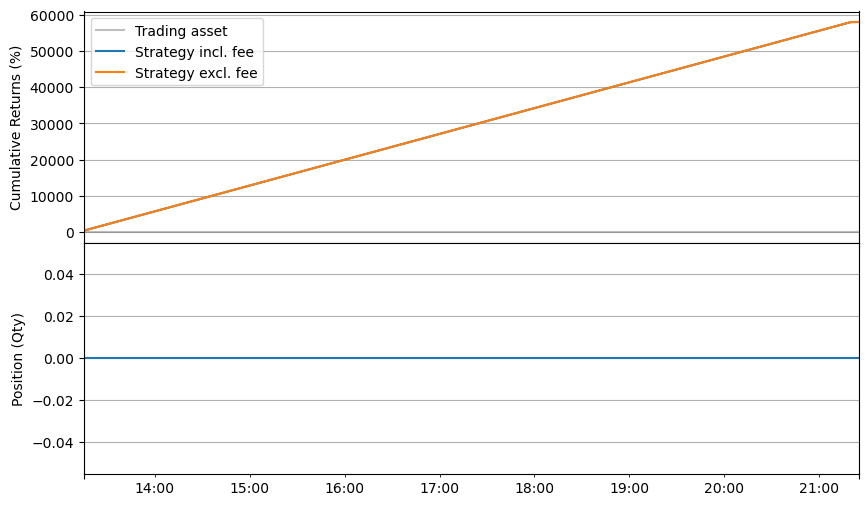

In [13]:
stat.summary(capital=2000, trading_days=1)

In [12]:
stat.positions()

In [14]:
from numba import njit

@njit
def print_3depth(hbt):
    while hbt.elapse(60 * 1e6):
        # a key of bid_depth or ask_depth is price in tick format.
        # (integer) price_tick = price / tick_size
        print('current_timestamp:', hbt.current_timestamp)
        i = 0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                print(
                    'ask: ',
                    hbt.ask_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
        i = 0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                print(
                    'bid: ',
                    hbt.bid_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
    return True


In [18]:
import numpy as np
btcusdt_20230405 = np.load('/home/danny/hftbacktest/snapshot1.npz')
btcusdt_20230404_eod = np.load('/home/danny/hftbacktest/test_dbn1.npz')
from hftbacktest import HftBacktest, FeedLatency, Linear

hbt = HftBacktest(
    [
        "/home/danny/hftbacktest/test_dbn1.npz"
    ],
    tick_size=0.01,
    lot_size=1,
    maker_fee=0,
    taker_fee=0.0,
    order_latency=FeedLatency(),
    # queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    exchange_model=PartialFillExchange,
    snapshot='/home/danny/hftbacktest/snapshot1.npz'
    # btcusdt_20230405,
    # tick_size=0.1,
    # lot_size=0.001,
    # maker_fee=0.0002,
    # taker_fee=0.0007,
    # order_latency=,
    # asset_type=Linear,
    # snapshot=btcusdt_20230404_eod
)

print_3depth(hbt)


Load /home/danny/hftbacktest/test_dbn1.npz
loaded
Data is loaded from arr_0 instead of 'data'
current_timestamp: 1702559878909000
ask:  200.0 @ 131.07
ask:  100.0 @ 131.08
ask:  200.0 @ 131.09
bid:  100.0 @ 135.03
bid:  100.0 @ 135.02
bid:  100.0 @ 135.01
current_timestamp: 1702559938909000
ask:  200.0 @ 131.07
ask:  100.0 @ 131.08
ask:  200.0 @ 131.09
bid:  100.0 @ 135.03
bid:  100.0 @ 135.02
bid:  100.0 @ 135.01
current_timestamp: 1702559998909000
ask:  200.0 @ 131.07
ask:  100.0 @ 131.08
ask:  200.0 @ 131.09
bid:  100.0 @ 135.03
bid:  100.0 @ 135.02
bid:  100.0 @ 135.01
current_timestamp: 1702560058909000
ask:  200.0 @ 131.07
ask:  100.0 @ 131.08
ask:  200.0 @ 131.09
bid:  100.0 @ 135.03
bid:  100.0 @ 135.02
bid:  100.0 @ 135.01
current_timestamp: 1702560118909000
ask:  200.0 @ 131.07
ask:  100.0 @ 131.08
ask:  200.0 @ 131.09
bid:  100.0 @ 135.03
bid:  100.0 @ 135.02
bid:  100.0 @ 135.01
current_timestamp: 1702560178909000
ask:  200.0 @ 131.07
ask:  100.0 @ 131.08
ask:  200.0 @ 131.

True